In [82]:

#df  manipulator
import pandas as pd
import random

# math lib
import numpy as np

import pickle

# chart lib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 


# Load data

In [83]:
flat_data = pd.read_csv('transaction_banking.csv')
flat_data.head(10)




,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [84]:
#factorize columns 
flat_data['factorized_type'] = pd.factorize(flat_data['type'])[0]

In [85]:
# flat_data.describe().round(2)
flat_data.isnull().any(axis=0)

step               False
type               False
amount             False
nameOrig           False
oldbalanceOrg      False
newbalanceOrig     False
nameDest           False
oldbalanceDest     False
newbalanceDest     False
isFraud            False
isFlaggedFraud     False
factorized_type    False
dtype: bool

In [86]:
# detect all anormal rows

anormal_transaction = flat_data.query('amount == 0')['step'].count()
print("il y a {} transaction nulle".format(anormal_transaction))
flat_data.describe().round(2)

il y a 16 transaction nulle


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,factorized_type
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0,1.69
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0,1.49
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0,0.00
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0,0.00
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0,2.00
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0,2.00
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0,4.00


In [87]:
flat_data = flat_data.query('amount != 0')

In [88]:


fraud_filter = flat_data[ flat_data['isFraud'] == 1]    \
    .groupby('type')   \
    .agg('sum')        \
    .reset_index()[ ['type', 'isFraud', 'amount'] ]  \
    .round(2)



#get fraud types
fraud_types = fraud_filter['type'].unique()
print('fraudulent transactions types as {}'.format( fraud_types ))

for x in fraud_filter.values:
    print('{} had been detected as fraud {} times for a total amount {} '.format(x[0], x[1], x[2]) )



fraudulent transactions types as ['CASH_OUT' 'TRANSFER']
CASH_OUT had been detected as fraud 4100 times for a total amount 5989202243.83 
TRANSFER had been detected as fraud 4097 times for a total amount 6067213184.01 


In [89]:
from sklearn.model_selection import train_test_split

column_features = ['factorized_type', 'amount', 'oldbalanceDest']
column_fraud = ['isFraud']

# create training and testing vars
x_train, x_test, y_train, y_test  \
    = train_test_split(flat_data[ column_features ], flat_data[ column_fraud ], test_size=0.2)



print('Training  Shape:', len(x_train) ) 
print('Testing   Shape:', len(x_test) ) 


Training  Shape: 5090083
Testing   Shape: 1272521


In [7]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
crf = RandomForestClassifier(n_estimators = 10, random_state = 42)

# Train the model on training data
crf.fit(x_train, y_train);

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [90]:
#save random forest model
filename = 'finalized_model_rf.sav'
#pickle.dump(crf, open(filename, 'wb'))

crf = pickle.load(open(filename, 'rb'))

In [106]:
# Use the forest's predict method on the test data
predictions = crf.predict(x_test)


# Calculate the absolute errors
errors = abs(predictions - y_test['isFraud'].values)
count_error = np.sum(errors)
accuracy = 1 - round(count_error * 100 / len(x_test), 2)

# Print out the mean absolute error (mae)
print('Algorithme failed to predict ', count_error, ' of ', len(x_test))
print('Failure perc : ' , accuracy, '%')
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

algorithme failed to predict  727  of  1272521
failure perc :  0.94 %
Mean Absolute Error: 0.0 degrees.


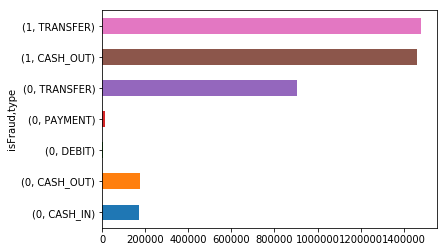

In [116]:
features = ['isFraud', 'type']
flat_data.groupby(features).agg('amount').mean().plot(kind='barh')

In [170]:
features = ['nameDest']
flat_data.query(' type in ["CASH_OUT", "TRANSFER"]  & isFraud == 1')    \
        .groupby( features )          \
        .agg('amount')                \
        .count()                      \
        .sort_values(ascending=False) \
        .reset_index()                \
        .groupby('amount')            \
        .count()                      \
        .reset_index()



,amount,nameDest
0,1,8111
1,2,43
